<a href="https://colab.research.google.com/github/qkrdudwls/Exploring-the-Bible-and-Quran-Books/blob/main/TextRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TextRank를 활용한 문장 유사도 분석**

## Overview
- Bible과 Quran을 chapter 별로 나누어서 crawling
- TextRank 알고리즘을 이용하여 keyword 추출 및 문장 요약
- 요약한 문장을 바탕으로 Cosine Similarity와 Jaccard Similarity 계산
- 요약한 데이터에 Shingling, Min-Hashing, LSH 알고리즘을 적용하여 유사도 계산 및 가장 유사한 문장 쌍 찾기


## Set up

### 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Selenium & chromedriver 설치

In [2]:
!pip install selenium
!apt-get update

!apt install chromium-chromedriver
!cp /usr/bin/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks'
!pip install chromedriver-autoinstaller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.6 MB/s eta 0:00:00
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,535 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,741 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,453

### Spark 설치

In [3]:
!pip install pyspark
!pip install -U -q PyDrive2
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 13.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=ba49bd37a074981a610fb59c1aeb1bee835ce52b428ab197c793a4aee5c719e0
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 3.2 MB/s eta 0:00:00
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  ope

### NLTK 패키지 설치
- punkt_tab 다운로드

In [4]:
import nltk
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

#### Version 확인

In [5]:
!python --version

import selenium
import pyspark
import nltk
import networkx
import sklearn

print(f"Selenium {selenium.__version__}")
print(f"PySpark {pyspark.__version__}")
print(f"NLTK {nltk.__version__}")
print(f"NetworkX {networkx.__version__}")
print(f"scikit-learn {sklearn.__version__}")

Python 3.10.12
Selenium 4.27.1
PySpark 3.5.3
NLTK 3.9.1
NetworkX 3.4.2
scikit-learn 1.5.2


### Import Library

In [6]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import sys
from selenium.webdriver.common.keys import Keys
import urllib.request
import os
from urllib.request import urlretrieve

import time
import pandas as pd
import chromedriver_autoinstaller
import re

import glob
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover
from pyspark.sql.functions import col, explode, udf, lower, regexp_replace
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, DoubleType
from pyspark.ml.linalg import SparseVector
import spacy
import nltk

import networkx as nx
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from itertools import combinations
import math
import hashlib
import numpy as np
from collections import defaultdict

### chrome_options 설정

In [7]:
chrome_path="/content/drive/Mydrive/Colab Notebooks/chromedriver"

sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

chromedriver_autoinstaller.install()

## Crawling

### URL

In [8]:
bible_url = 'https://www.gutenberg.org/cache/epub/10/pg10-images.html'
quran_url = 'https://www.gutenberg.org/cache/epub/2800/pg2800-images.html'

### 데이터 전처리 함수
- 문장 단위로 분할
- 영어 알파벳과 공백, 마침표만 제외하고 모두 제거
- 모든 문자를 소문자로 변환
- 연속된 공백을 단일 공백으로 축소
- 양 끝의 공백 제거

In [9]:
def preprocess_text(text):
    sentences = re.split(r'(?<=[.?!])\s+', text)

    cleaned_sentences = []
    for sentence in sentences:
        sentence = re.sub(r'[?!]', '.', sentence)
        cleaned_sentence = re.sub(r'[^a-zA-Z\s.]', '', sentence)
        cleaned_sentence = cleaned_sentence.lower()
        cleaned_sentence = re.sub(r'\s+', ' ', cleaned_sentence).strip()
        cleaned_sentence = re.sub(r'\.{2,}', '.', cleaned_sentence)
        cleaned_sentences.append(cleaned_sentence)

    return '. '.join(cleaned_sentences)

### Bible

In [10]:
bible_chapter_driver = webdriver.Chrome(options=chrome_options)
bible_chapter_driver.get(bible_url)
wait = WebDriverWait(bible_chapter_driver, 10)

output_folder = "bible_texts"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

try:
    chapter_divs = bible_chapter_driver.find_elements(By.CLASS_NAME, "chapter")

    for index, chapter_div in enumerate(chapter_divs[1:], start=2):
        p_elements = chapter_div.find_elements(By.TAG_NAME, "p")

        chapter_text = ""
        for p_element in p_elements:
            text = p_element.text.strip()
            if text:
                processed_text = preprocess_text(text)
                chapter_text += processed_text + "\n"

        if chapter_text.strip():
            filename = os.path.join(output_folder, f"chapter_{index-1}.txt")
            with open(filename, "w", encoding="utf-8") as file:
                file.write(chapter_text.strip())
            print(f"Saved chapter {index-1} to {filename}")

except Exception as e:
    print("Error:", e)

finally:
    bible_chapter_driver.quit()

Saved chapter 1 to bible_texts/chapter_1.txt
Saved chapter 2 to bible_texts/chapter_2.txt
Saved chapter 3 to bible_texts/chapter_3.txt
Saved chapter 4 to bible_texts/chapter_4.txt
Saved chapter 5 to bible_texts/chapter_5.txt
Saved chapter 6 to bible_texts/chapter_6.txt
Saved chapter 7 to bible_texts/chapter_7.txt
Saved chapter 8 to bible_texts/chapter_8.txt
Saved chapter 9 to bible_texts/chapter_9.txt
Saved chapter 10 to bible_texts/chapter_10.txt
Saved chapter 11 to bible_texts/chapter_11.txt
Saved chapter 12 to bible_texts/chapter_12.txt
Saved chapter 13 to bible_texts/chapter_13.txt
Saved chapter 14 to bible_texts/chapter_14.txt
Saved chapter 15 to bible_texts/chapter_15.txt
Saved chapter 16 to bible_texts/chapter_16.txt
Saved chapter 17 to bible_texts/chapter_17.txt
Saved chapter 18 to bible_texts/chapter_18.txt
Saved chapter 19 to bible_texts/chapter_19.txt
Saved chapter 20 to bible_texts/chapter_20.txt
Saved chapter 21 to bible_texts/chapter_21.txt
Saved chapter 22 to bible_texts

### Quran

In [11]:
quran_chapter_driver = webdriver.Chrome(options=chrome_options)
quran_chapter_driver.get(quran_url)
wait = WebDriverWait(quran_chapter_driver, 10)

output_dir = 'quran_texts'
os.makedirs(output_dir, exist_ok=True)

current_document = []
chapter_count = 1
start_crawling = False

try:
    elements = quran_chapter_driver.find_elements(By.XPATH, "//*[name()='h4' or name()='p' or @id='pg-end-separator']")

    for element in elements:
        if element.tag_name == 'div' and element.get_attribute('id') == 'pg-end-separator':
            break

        if element.tag_name == 'h4':
            start_crawling = True

            if current_document:
                quran_processed_text = ''.join(current_document)

                with open(os.path.join(output_dir, f'chapter_{chapter_count}.txt'), 'w', encoding='utf-8') as file:
                    file.write(quran_processed_text)

                print(f"Saved chapter {chapter_count} to {output_dir}/chapter_{chapter_count}.txt")

                chapter_count += 1
                current_document = []

        if start_crawling and element.tag_name == 'p':
            raw_text = element.text.strip()
            processed_text = preprocess_text(raw_text)
            current_document.append(processed_text + '\n')

    if current_document:
        quran_processed_text = ''.join(current_document)
        with open(os.path.join(output_dir, f'chapter_{chapter_count}.txt'), 'w', encoding='utf-8') as file:
            file.write(quran_processed_text)
        print(f"Saved chapter {chapter_count} to {output_dir}/chapter_{chapter_count}.txt")

except Exception as e:
    print("Error:", e)

finally:
    quran_chapter_driver.quit()

Saved chapter 1 to quran_texts/chapter_1.txt
Saved chapter 2 to quran_texts/chapter_2.txt
Saved chapter 3 to quran_texts/chapter_3.txt
Saved chapter 4 to quran_texts/chapter_4.txt
Saved chapter 5 to quran_texts/chapter_5.txt
Saved chapter 6 to quran_texts/chapter_6.txt
Saved chapter 7 to quran_texts/chapter_7.txt
Saved chapter 8 to quran_texts/chapter_8.txt
Saved chapter 9 to quran_texts/chapter_9.txt
Saved chapter 10 to quran_texts/chapter_10.txt
Saved chapter 11 to quran_texts/chapter_11.txt
Saved chapter 12 to quran_texts/chapter_12.txt
Saved chapter 13 to quran_texts/chapter_13.txt
Saved chapter 14 to quran_texts/chapter_14.txt
Saved chapter 15 to quran_texts/chapter_15.txt
Saved chapter 16 to quran_texts/chapter_16.txt
Saved chapter 17 to quran_texts/chapter_17.txt
Saved chapter 18 to quran_texts/chapter_18.txt
Saved chapter 19 to quran_texts/chapter_19.txt
Saved chapter 20 to quran_texts/chapter_20.txt
Saved chapter 21 to quran_texts/chapter_21.txt
Saved chapter 22 to quran_texts

## TextRank
- Bible과 Quran의 키워드 추출 및 문장 요약
1. 문장 및 단어 토큰화
2. TF-IDF 임베딩 생성
3. 코사인 유사도로 유사도 행렬 생성
4. 그래프 생성 및 PageRank 계산
5. 상위 3개 문장을 요약으로 추출


### Bible

In [12]:
spark = SparkSession.builder.appName("TextRank Summary of the Bible").getOrCreate()

data_dir = "/content/bible_texts"
text_files = [(file, open(os.path.join(data_dir, file), "r", encoding="utf-8").read()) for file in os.listdir(data_dir) if file.endswith(".txt")]
df = spark.createDataFrame(text_files, ["filename", "text"])

def textrank_summary_and_keywords(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text.lower())

    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)

    similarity_matrix = cosine_similarity(sentence_vectors)

    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)

    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    summary = " ".join([ranked_sentences[i][1] for i in range(min(3, len(ranked_sentences)))])

    keywords = " ".join(sorted(set(words), key=words.count, reverse=True)[:10])

    return summary, keywords

textrank_udf = udf(lambda text: textrank_summary_and_keywords(text)[0], StringType())
keywords_udf = udf(lambda text: textrank_summary_and_keywords(text)[1], StringType())

df = df.withColumn("summary", textrank_udf(df.text))
df = df.withColumn("keywords", keywords_udf(df.text))

result_df = df.select("filename", "summary", "keywords").toPandas()

output_dir = "/content/bible_summaries"
os.makedirs(output_dir, exist_ok=True)

for index, row in result_df.iterrows():
    chapter_filename = row['filename'].replace(".txt", "_summary.txt")
    output_path = os.path.join(output_dir, chapter_filename)

    with open(output_path, "w") as file:
        summary_text = f"Filename: {row['filename']}\nSummary: {row['summary']}\nKeywords: {row['keywords']}\n"
        file.write(summary_text)

spark.stop()

### Quran

In [13]:
spark = SparkSession.builder.appName("TextRank Summary of the Quran").getOrCreate()

data_dir = "/content/quran_texts"
text_files = [(file, open(os.path.join(data_dir, file), "r", encoding="utf-8").read()) for file in os.listdir(data_dir) if file.endswith(".txt")]
df = spark.createDataFrame(text_files, ["filename", "text"])

def textrank_summary_and_keywords(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text.lower())

    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)

    similarity_matrix = cosine_similarity(sentence_vectors)

    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)

    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    summary = " ".join([ranked_sentences[i][1] for i in range(min(3, len(ranked_sentences)))])

    keywords = " ".join(sorted(set(words), key=words.count, reverse=True)[:10])

    return summary, keywords

textrank_udf = udf(lambda text: textrank_summary_and_keywords(text)[0], StringType())
keywords_udf = udf(lambda text: textrank_summary_and_keywords(text)[1], StringType())

df = df.withColumn("summary", textrank_udf(df.text))
df = df.withColumn("keywords", keywords_udf(df.text))

result_df = df.select("filename", "summary", "keywords").toPandas()

output_dir = "/content/quran_summaries"
os.makedirs(output_dir, exist_ok=True)

for index, row in result_df.iterrows():
    chapter_filename = row['filename'].replace(".txt", "_summary.txt")
    output_path = os.path.join(output_dir, chapter_filename)

    with open(output_path, "w") as file:
        summary_text = f"Filename: {row['filename']}\nSummary: {row['summary']}\nKeywords: {row['keywords']}\n"
        file.write(summary_text)

spark.stop()

## Similarity
- bible_summary.txt와 quran_summary.txt를 사용하여 Bible과 Quran의 유사도 계산

### Cosine Similarity & Jaccard Similarity

In [14]:
spark = SparkSession.builder.appName("Bible vs Quran Similarity").getOrCreate()

bible_dir = "/content/bible_summaries"
quran_dir = "/content/quran_summaries"

bible_texts = []
for file in os.listdir(bible_dir):
    with open(os.path.join(bible_dir, file), "r", encoding="utf-8") as f:
        bible_texts.append(f.read())
bible_combined_text = " ".join(bible_texts)

quran_texts = []
for file in os.listdir(quran_dir):
    with open(os.path.join(quran_dir, file), "r", encoding="utf-8") as f:
        quran_texts.append(f.read())
quran_combined_text = " ".join(quran_texts)

texts = [("bible", bible_combined_text), ("quran", quran_combined_text)]
df = spark.createDataFrame(texts, ["text_id", "text"])

texts = [row.text for row in df.collect()]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)
cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

def jaccard_similarity(text1, text2):
    words_text1 = set(text1.split())
    words_text2 = set(text2.split())
    intersection = words_text1.intersection(words_text2)
    union = words_text1.union(words_text2)
    return float(len(intersection)) / len(union)

jaccard_sim = jaccard_similarity(texts[0], texts[1])

spark.stop()

## Shingling & Min-Hashing & LSH

### Shingling

In [15]:
n = 3

def create_shingles_from_dir(directory_path, n):
    combined_text = ""
    for file_name in os.listdir(directory_path):
        if file_name.endswith(".txt"):
            with open(os.path.join(directory_path, file_name), "r", encoding="utf-8") as file:
                combined_text += file.read().replace('\n', ' ') + " "

    shingles = set()
    for i in range(len(combined_text) - n + 1):
        shingles.add(combined_text[i:i + n])

    return shingles

bible_dir = "/content/bible_summaries"
quran_dir = "/content/quran_summaries"

bible_shingles = create_shingles_from_dir(bible_dir, n)
quran_shingles = create_shingles_from_dir(quran_dir, n)

print("Bible Shingles 개수:", len(bible_shingles))
print("Quran Shingles 개수:", len(quran_shingles))
print("Bible Shingles (일부):", list(bible_shingles)[:5])
print("Quran Shingles (일부):", list(quran_shingles)[:5])

Bible Shingles 개수: 3268
Quran Shingles 개수: 3783
Bible Shingles (일부): ['sle', ' ef', 'arm', 'u f', 'aso']
Quran Shingles (일부): ['egl', 'sle', 'uma', ' ef', 'ndy']


#### Shingles 간 유사도 측정

In [16]:
def cosine_similarity(set1, set2):
    counter1 = Counter(set1)
    counter2 = Counter(set2)

    common_shingles = set1 & set2
    dot_product = sum(counter1[shingle] * counter2[shingle] for shingle in common_shingles)

    magnitude1 = math.sqrt(sum(value**2 for value in counter1.values()))
    magnitude2 = math.sqrt(sum(value**2 for value in counter2.values()))

    return dot_product / (magnitude1 * magnitude2)

def jaccard_similarity(set1, set2):
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

cosine_sim_shingles = cosine_similarity(bible_shingles, quran_shingles)
print("Cosine 유사도:", cosine_sim_shingles)

jaccard_sim_shingles = jaccard_similarity(bible_shingles, quran_shingles)
print("Jaccard 유사도:", jaccard_sim_shingles)

Cosine 유사도: 0.7963405610318188
Jaccard 유사도: 0.6586685485768055


### Min-Hashing

#### 함수 정의

In [17]:
def minhash(shingles, num_hashes):
    min_hashes = [float('inf')] * num_hashes
    hash_collisions = [0] * num_hashes
    seen_hashes = [set() for _ in range(num_hashes)]

    for shingle in shingles:
        for i in range(num_hashes):
            hash_val = int(hashlib.sha256((str(i) + shingle).encode('utf-8')).hexdigest(), 16)
            if hash_val in seen_hashes[i]:
                hash_collisions[i] += 1
            else:
                seen_hashes[i].add(hash_val)
            min_hashes[i] = min(min_hashes[i], hash_val)
    return min_hashes, hash_collisions

def jaccard_similarity_minhash(minhash1, minhash2):
    assert len(minhash1) == len(minhash2), "Minhash 리스트의 길이가 동일해야 합니다."
    return sum(1 for i in range(len(minhash1)) if minhash1[i] == minhash2[i]) / len(minhash1)

def total_hash_collisions(collisions):
    return sum(collisions)

#### 유사도 측정

In [19]:
num_hashes = 200
bible_minhash, bible_collisions = minhash(bible_shingles, num_hashes)
quran_minhash, quran_collisions = minhash(quran_shingles, num_hashes)

minhash_similarity = jaccard_similarity_minhash(bible_minhash, quran_minhash)
total_collisions = total_hash_collisions(bible_collisions + quran_collisions)

print("Bible Minhash (일부):", bible_minhash[:5])
print("Quran Minhash (일부):", quran_minhash[:5])
print("Jaccard 유사도:", minhash_similarity)
print(f"Total Hash Collisions: {total_collisions}")

Bible Minhash (일부): [142007963374010426382138725585633728632670059153182797619995424413205190370, 61029995696528839340681556490283563750113136299084301253556274255311383867, 74482003611007926343735746953205952575243904011463384538829221738236893738, 13303050268803375994217044805968259787349693676690538745035727233009340612, 2304439068908944944830965196945721431575249734642627760810988191669108179]
Quran Minhash (일부): [142007963374010426382138725585633728632670059153182797619995424413205190370, 61029995696528839340681556490283563750113136299084301253556274255311383867, 53680818324743862649857533326054318705475454322943123511963264584711140609, 13303050268803375994217044805968259787349693676690538745035727233009340612, 16943634624084268649050095407251787582290238634288236651595211279939668427]
Jaccard 유사도: 0.62
Total Hash Collisions: 0


#### Visualize

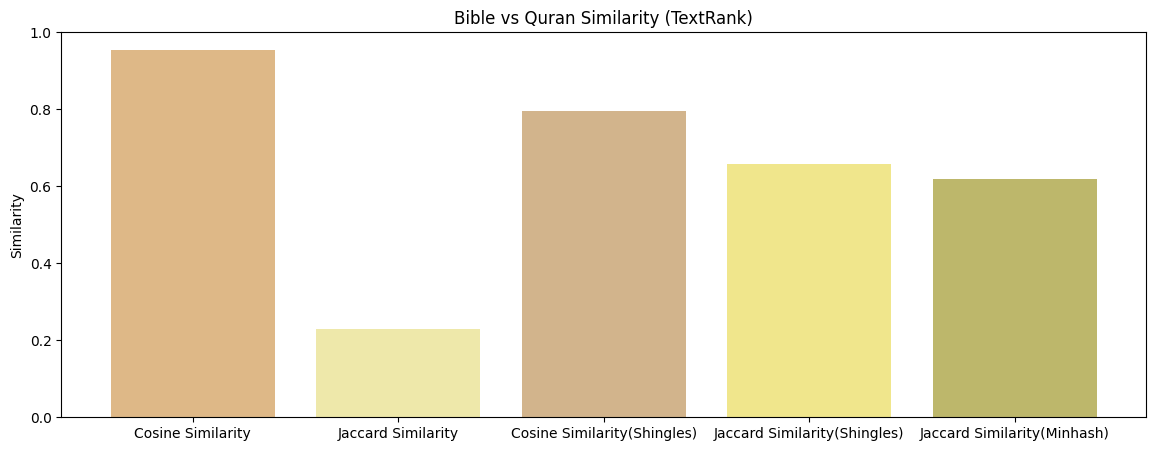

--Similarity--
Cosine: 0.954988788405355
Jaccard: 0.22968274663189917
Cosine(Shingles): 0.7963405610318188
Jaccard(Shingles): 0.6586685485768055
Jaccard(Minhash): 0.62
-------------------------------------------
Similarity (Percentage)
Cosine:95.4988788405355%
Jaccard:22.968274663189916%
Cosine(Shingles): 79.63405610318188%
Jaccard(Shingles): 65.86685485768055%
Jaccard(Minhash): 62.0%


In [20]:
labels = ['Cosine Similarity', 'Jaccard Similarity', 'Cosine Similarity(Shingles)', 'Jaccard Similarity(Shingles)','Jaccard Similarity(Minhash)']
similarities = [cosine_sim, jaccard_sim, cosine_sim_shingles, jaccard_sim_shingles, minhash_similarity]

plt.figure(figsize=(14, 5))
plt.bar(labels, similarities, color=['burlywood', 'palegoldenrod', 'tan', 'khaki', 'darkkhaki'])
plt.ylim(0, 1)
plt.ylabel('Similarity')
plt.title("Bible vs Quran Similarity (TextRank)")
plt.show()

print("--Similarity--")
print(f"Cosine: {cosine_sim}")
print(f"Jaccard: {jaccard_sim}")
print(f"Cosine(Shingles): {cosine_sim_shingles}")
print(f"Jaccard(Shingles): {jaccard_sim_shingles}")
print(f"Jaccard(Minhash): {minhash_similarity}")
print("-------------------------------------------")
print("Similarity (Percentage)")
print(f"Cosine:{cosine_sim*100}%")
print(f"Jaccard:{jaccard_sim*100}%")
print(f"Cosine(Shingles): {cosine_sim_shingles*100}%")
print(f"Jaccard(Shingles): {jaccard_sim_shingles*100}%")
print(f"Jaccard(Minhash): {minhash_similarity*100}%")

### LSH

#### LSH 알고리즘 구현 및 유사한 문장 쌍을 찾는 함수 정의

In [21]:
def lsh(minhash_vectors, num_bands, rows_per_band):
    assert len(minhash_vectors[0]) == num_bands * rows_per_band, "MinHash 벡터의 길이가 밴드와 행 개수에 맞아야 합니다."

    lsh_buckets = defaultdict(list)
    for doc_id, minhash_vector in enumerate(minhash_vectors):
        for band in range(num_bands):
            start = band * rows_per_band
            end = start + rows_per_band
            band_hash = hash(tuple(minhash_vector[start:end]))
            lsh_buckets[(band, band_hash)].append(doc_id)

    return lsh_buckets

def find_similar_pairs(lsh_buckets, minhash_vectors, threshold=0.6):
    candidate_pairs = set()
    for bucket in lsh_buckets.values():
        if len(bucket) > 1:
            for i in range(len(bucket)):
                for j in range(i + 1, len(bucket)):
                    candidate_pairs.add((bucket[i], bucket[j]))

    similar_pairs = []
    for doc1, doc2 in candidate_pairs:
        jaccard_sim = jaccard_similarity_minhash(minhash_vectors[doc1], minhash_vectors[doc2])
        if jaccard_sim >= threshold:
            similar_pairs.append((doc1, doc2, jaccard_sim))

    return similar_pairs

#### 유사한 문장 쌍 찾기

In [22]:
def read_documents_from_dir(directory):
    documents = []
    for file_name in os.listdir(directory):
        if file_name.endswith(".txt"):
            with open(os.path.join(directory, file_name), "r", encoding="utf-8") as file:
                documents.append(file.read())
    return documents

bible_documents = read_documents_from_dir(bible_dir)
quran_documents = read_documents_from_dir(quran_dir)

num_bands = 200
rows_per_band = len(bible_minhash) // num_bands

minhash_vectors = [bible_minhash, quran_minhash]
lsh_buckets = lsh(minhash_vectors, num_bands, rows_per_band)

threshold = 0.6
similar_pairs = find_similar_pairs(lsh_buckets, minhash_vectors, threshold)

if similar_pairs:
    print("유사한 문장 쌍:")
    for doc1, doc2, sim in similar_pairs:
        source1 = "Bible" if doc1 == 0 else "Quran"
        source2 = "Bible" if doc2 == 0 else "Quran"
        print(f"{source1}:\n{bible_documents[doc1] if doc1 == 0 else quran_documents[doc1]}")
        print(f"{source2}:\n{bible_documents[doc2] if doc2 == 0 else quran_documents[doc2]}")
        print(f"유사도: {sim:.2f}\n")
else:
    print("유사한 문장이 발견되지 않았습니다.")

유사한 문장 쌍:
Bible:
Filename: chapter_46.txt
Summary: but now the righteousness of god without the law is manifested being witnessed by the law and the prophets even the righteousness of god which is by faith of jesus christ unto all and upon all them that believe for there is no difference for all have sinned and come short of the glory of god being justified freely by his grace through the redemption that is in christ jesus whom god hath set forth to be a propitiation through faith in his blood to declare his righteousness for the remission of sins that are past through the forbearance of god to declare i say at this time his righteousness that he might be just and the justifier of him which believeth in jesus. therefore it is of faith that it might be by grace to the end the promise might be sure to all the seed not to that only which is of the law but to that also which is of the faith of abraham who is the father of us all as it is written i have made thee a father of many nations be